In [ ]:
!pip install torchxrayvision

### Importing some useful libraries

In [ ]:
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import pandas as pd
import torchxrayvision as xrv
import torchvision, torchvision.transforms
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image

Establishing connection to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the model for extraction of 18 features

In [ ]:
nn_model = xrv.models.DenseNet(weights="all")
nn_model.op_threshs = None 

Object for resize and cropping of images

In [ ]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

 Defining the path of the folder with the images

In [ ]:
## PLACE THE PATH WHERE ARE FOUND THE IMAGES THAT WILL PASS THROUGH THE MODEL
## (EXTRACTION OF THE 18 PATHOLOGIES)

path_folder_images = '/content/drive/MyDrive/Data - Proyecto - Diplomado/test/normal/'

Saving the names of the images

In [ ]:
path_images = []
filenames = []

for name in os.listdir(path_folder_images):
    path_images.append(path_folder_images + name)
    filenames.append(name)

In [ ]:
filenames[:5]

['NORMAL2-IM-0949-0001.jpeg',
 'NORMAL2-IM-0941-0001.jpeg',
 'NORMAL2-IM-0936-0001.jpeg',
 'NORMAL2-IM-0931-0001.jpeg',
 'NORMAL2-IM-0930-0001.jpeg']

Definition of the dataframe with the names of the images

In [ ]:
dict_images = {'filename': filenames}
df_images = pd.DataFrame(dict_images)
df_images

,filename
0,NORMAL2-IM-0949-0001.jpeg
1,NORMAL2-IM-0941-0001.jpeg
2,NORMAL2-IM-0936-0001.jpeg
3,NORMAL2-IM-0931-0001.jpeg
4,NORMAL2-IM-0930-0001.jpeg
...,...
239,NORMAL2-IM-0887-0001.jpeg
240,NORMAL2-IM-0893-0001.jpeg
241,NORMAL2-IM-0888-0001.jpeg
242,NORMAL2-IM-0898-0001.jpeg


Defining the path to be saved the above dataframe as a .csv file

In [ ]:
## PLACE THE PATH WHERE THE .csv FILE WILL BE SAVED
## THE .csv FILE CONTAINS THE NAMES OF ALL THE IMAGES -------> path_csv = ' '

path_csv = '/content/drive/MyDrive/Data - Proyecto - Diplomado/test/'
df_images.to_csv(path_csv + 'csv_images.csv', index=False)

Showing one of the images to be analysed

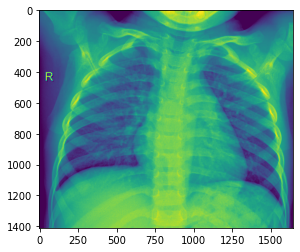


/content/drive/MyDrive/Data - Proyecto - Diplomado/test/normal/NORMAL2-IM-0949-0001.jpeg


In [ ]:
imagen = xrv.datasets.imread(path_images[0])
plt.imshow(imagen)
plt.show()
print()
print(path_images[0])

Definition of the Dataloader

In [ ]:
class ChestImagesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = read_image(img_path)
        name = self.annotations.iloc[index, 0]

        if self.transform:
            image = self.transform(image)
  
        return image, name

Loading the images

In [ ]:
names_file = path_csv + 'csv_images.csv'

dataset = ChestImagesDataset(csv_file=names_file, root_dir=path_folder_images, transform=transform)
dl = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, num_workers=64, pin_memory=True)

Extracting the 18 pathologies

In [ ]:
dl_18features = []

with torch.no_grad():
    for batch_images, batch_names in dl:
        features = nn_model(batch_images)
        dl_18features.append(features.detach().cpu().numpy())
        print(batch_names)
            
dl_18features = np.concatenate(dl_18features)

('NORMAL2-IM-0949-0001.jpeg', 'NORMAL2-IM-0941-0001.jpeg', 'NORMAL2-IM-0936-0001.jpeg', 'NORMAL2-IM-0931-0001.jpeg', 'NORMAL2-IM-0930-0001.jpeg', 'NORMAL2-IM-0926-0001.jpeg', 'NORMAL2-IM-0923-0001.jpeg', 'NORMAL2-IM-0922-0001.jpeg', 'NORMAL2-IM-0917-0001.jpeg', 'NORMAL2-IM-0909-0001.jpeg', 'NORMAL2-IM-0908-0001.jpeg', 'NORMAL2-IM-0900-0001.jpeg', 'NORMAL2-IM-0993-0001.jpeg', 'NORMAL2-IM-0986-0001.jpeg', 'NORMAL2-IM-0981-0001.jpeg', 'NORMAL2-IM-0983-0001.jpeg', 'NORMAL2-IM-0989-0001.jpeg', 'NORMAL2-IM-0987-0001.jpeg', 'NORMAL2-IM-0971-0001-0002.jpeg', 'NORMAL2-IM-0971-0001-0001.jpeg', 'NORMAL2-IM-0966-0001.jpeg', 'NORMAL2-IM-0962-0001.jpeg', 'NORMAL2-IM-0960-0001.jpeg', 'NORMAL2-IM-0956-0001.jpeg', 'NORMAL2-IM-0954-0001.jpeg', 'NORMAL2-IM-0951-0001.jpeg', 'IM-0027-0001.jpeg', 'IM-0028-0001.jpeg', 'IM-0030-0001.jpeg', 'IM-0033-0001-0002.jpeg', 'IM-0023-0001.jpeg', 'IM-0017-0001.jpeg')
('IM-0010-0001.jpeg', 'IM-0011-0001-0001.jpeg', 'IM-0109-0001.jpeg', 'IM-0061-0001.jpeg', 'IM-0210-0001.

In [ ]:
dl_18features.shape

(244, 18)

Ordering the 18 pathologies for all the images analysed

In [ ]:
Atelectasis = []
Consolidation = []
Infiltration = []
Pneumothorax = []
Edema = []
Emphysema = []
Fibrosis = []
Effusion = []
Pneumonia = []
Pleural_Thickening = []
Cardiomegaly = []
Nodule = []
Mass = []
Hernia = []
Lung_Lesion = []
Fracture = []
Lung_Opacity = []
Enlarged_Cardiomediastinum = []

pathologies = [Atelectasis, Consolidation, Infiltration, Pneumothorax, Edema, Emphysema, Fibrosis, Effusion, Pneumonia, Pleural_Thickening, Cardiomegaly, Nodule, Mass, Hernia, Lung_Lesion, Fracture, Lung_Opacity, Enlarged_Cardiomediastinum]

for i in range(dl_18features.shape[0]):
    for j in range(dl_18features.shape[1]):
        pathologies[j].append(dl_18features[i][j])

Defining the name of the .csv file for saving the 18 pathologies

In [ ]:
## PUT A NAME TO THE .csv FILE THAT WILL CONTAIN THE 18 PATHOLOGIES OF THE IMAGES THAT PASSED THROUGH THE MODEL

name_csv = 'csv_TestNormal_pathologies.csv'

Creating a dataframe with the result of the 18 pathologies and saving it to a .csv file

In [ ]:
dict_pathologies = {'filename': filenames,
                    'Atelectasis': pathologies[0],
                    'Consolidation': pathologies[1],
                    'Infiltration': pathologies[2],
                    'Pneumothorax': pathologies[3],
                    'Edema': pathologies[4],
                    'Emphysema': pathologies[5],
                    'Fibrosis': pathologies[6],
                    'Effusion': pathologies[7],
                    'Pneumonia': pathologies[8],
                    'Pleural_Thickening': pathologies[9],
                    'Cardiomegaly': pathologies[10],
                    'Nodule': pathologies[11],
                    'Mass': pathologies[12],
                    'Hernia': pathologies[13],
                    'Lung Lesion': pathologies[14],
                    'Fracture': pathologies[15],
                    'Lung Opacity': pathologies[16],
                    'Enlarged Cardiomediastinum': pathologies[17]}

df_pathologies = pd.DataFrame(dict_pathologies)

## Cambiar el nombre del archivo .csv dependiendo de la carpeta
df_pathologies.to_csv(path_csv + name_csv, index=False)
df_pathologies

,filename,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Lung Lesion,Fracture,Lung Opacity,Enlarged Cardiomediastinum
0,NORMAL2-IM-0949-0001.jpeg,-1.373993,-2.012837,-2.150867,-3.242758,-2.549309,-3.380933,-3.606853,-1.577569,-1.044707,-2.702723,-2.087657,-2.637047,-2.041176,-5.100240,-4.153739,-2.880867,0.268526,-1.571701
1,NORMAL2-IM-0941-0001.jpeg,-1.194285,-1.953827,-2.199917,-3.281570,-2.495366,-2.959090,-3.970770,-1.586534,-0.620559,-2.750345,-2.019573,-2.711023,-2.230649,-4.726227,-3.680006,-2.845274,0.091522,-1.629077
2,NORMAL2-IM-0936-0001.jpeg,-1.714395,-2.083853,-2.348757,-3.669208,-3.059209,-3.753505,-4.414954,-2.350452,-1.340740,-3.184497,-2.819042,-2.885444,-2.280382,-6.036270,-5.596185,-3.319542,0.637498,-1.606954
3,NORMAL2-IM-0931-0001.jpeg,-1.372932,-2.001730,-2.277263,-3.583696,-2.616183,-3.439270,-4.382102,-1.880315,-0.777731,-3.220853,-2.333597,-2.809276,-2.359067,-5.639915,-4.666625,-3.114288,0.442935,-1.615803
4,NORMAL2-IM-0930-0001.jpeg,-1.269175,-1.852105,-1.950903,-3.106267,-2.458437,-3.217555,-3.210180,-1.302467,-0.946282,-2.501194,-2.089205,-2.504247,-1.880066,-4.859195,-3.862182,-2.784812,0.506268,-1.477743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,NORMAL2-IM-0887-0001.jpeg,-1.316482,-1.892359,-1.988609,-3.008137,-2.403020,-3.148902,-3.315621,-1.531422,-0.950093,-2.494736,-2.244809,-2.472280,-1.915197,-4.691921,-4.085465,-2.710300,0.447920,-1.596818
240,NORMAL2-IM-0893-0001.jpeg,-1.014472,-1.580834,-1.604839,-2.740064,-2.082506,-3.481181,-2.111728,-0.504829,-1.458356,-1.652541,-1.486330,-2.337456,-1.476716,-3.750444,-2.517079,-2.256520,0.192012,-1.307994
241,NORMAL2-IM-0888-0001.jpeg,-1.380886,-2.043701,-2.285738,-3.356516,-2.597893,-3.234544,-3.917440,-2.015302,-1.068100,-2.768741,-2.169947,-2.728014,-2.084797,-4.843187,-4.543862,-2.859207,0.188887,-1.618786
242,NORMAL2-IM-0898-0001.jpeg,-1.189206,-1.742217,-1.811654,-3.058293,-2.309887,-3.365764,-2.944232,-0.992249,-1.032559,-2.396819,-1.973860,-2.471591,-1.827557,-5.004114,-3.576462,-2.748213,0.594254,-1.403285
